In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import torch
import os
import pandas as pd
import torch.nn as nn
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Dataset
 
from tqdm import tqdm
from utils.london.process_data import build_train_test_loaders, build_train_test_loaders_2
from utils.london.training import CustomMAELoss, CustomMAPELoss, test_model, get_flow_forecasting_metrics
from utils.london.link_loads import get_graph_attributes, df_to_graph, build_quarter_hour_data, add_missing_nodes, add_missing_nodes_2
from utils.london.models import STGCN
# import networkx as nx

- Charger les csv
- Supprimer les horaires 00h - 05h
- Les save by jour
- Créer la class Dataset qui renvoie le graph actuel avec les flows précédent dans la journée.

In [3]:
folder_path = "data/london/"
# Get graph attributes, create dfs from csv, process Link column and ordered dfs by time
num_nodes, edge_index, node_mapping, dfs = get_graph_attributes(folder_path)

# Training

In [5]:
MAE = CustomMAELoss()
MAPE = CustomMAPELoss()

### GCN + GRU (pas concluant, ne pas run)

In [ ]:
graph_data = []
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    df = add_missing_nodes(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = build_quarter_hour_data(df, filename, num_nodes) # retourne 24*4 df avec ses paramètres temporel et le flow
    graph_data.extend(df_qhrs)
    
graphs = [df_to_graph(df, edge_index) for df in graph_data]  # Un graphe par quart d'heure

In [48]:
class TGCN(nn.Module):
    def __init__(self, node_features, hidden_dim, gru_hidden_dim):
        super(TGCN, self).__init__()
        self.gcn = GCNConv(node_features, hidden_dim)  # GCN
        self.gru = nn.GRU(hidden_dim, gru_hidden_dim, batch_first=True)  # GRU
        self.fc = nn.Linear(gru_hidden_dim, 1)  # Prédiction finale

    def forward(self, graph_seq):
        # window_size = len(graph_seq)  # Nombre de pas de temps
        # batch_size = graph_seq[0].x.shape[0]  # Nombre de nœuds

        spatial_features = []
        for graph in graph_seq:
            x = self.gcn(graph.x, graph.edge_index)  # GCN
            x = F.relu(x)
            spatial_features.append(x)

        spatial_features = torch.stack(spatial_features, dim=1)  # (batch, time, hidden_dim)

        _ , final_state = self.gru(spatial_features)  # prédiction sur le dernier (1, gru_hidden_dim)
        final_state = final_state.squeeze() # (gru_hidden_dim)
        final_out = self.fc(final_state) # Prédiction sur le dernier état
        final_out = F.relu(final_out)
        return final_out

In [24]:
graphs[0]

Data(x=[1187, 10], edge_index=[2, 3946], y=[1187, 1])

In [50]:
model = TGCN(node_features=10, hidden_dim=32, gru_hidden_dim=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = MAE

# Boucle d'entraînement
for epoch in tqdm(range(50)):
    model.train()
    total_loss = 0
    for graph_seq, target in train_loader:
        optimizer.zero_grad()
        output = model(graph_seq)

        target = target.squeeze()
        output = output.reshape(target.shape)
    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


  2%|▏         | 1/50 [00:44<36:16, 44.42s/it]

Epoch 1, Loss: 256.43267001944605


  4%|▍         | 2/50 [01:29<35:38, 44.55s/it]

Epoch 2, Loss: 256.43267001944605


  4%|▍         | 2/50 [01:32<36:58, 46.21s/it]


KeyboardInterrupt: 

In [19]:
model.eval()
test_loss = 0
with torch.no_grad():
    for graph_seq, target in test_loader:

        output = model(graph_seq)
        loss = criterion(output, target)
        test_loss += loss.item()

print(f"Test MAE: {test_loss / len(test_loader)}")


Test MAE: 204.33262727453592


In [22]:
39e6/(96*1206)

336.8573797678275

The average flow per inter_station per 15min is 337. So 204 MAE error is not a valid result.

### GCN with past flows as node features

In [76]:
graph_data = []
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    df = add_missing_nodes(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = build_quarter_hour_data(df, filename, num_nodes) # retourne 24*4 df avec ses paramètres temporel et le flow
    graph_data.extend(df_qhrs)
    
graphs = [df_to_graph(df, edge_index) for df in graph_data]  # Un graphe par quart d'heure

window_size=4

train_loader, test_loader = build_train_test_loaders(graphs, window_size)

In [56]:
loss_mae = 0
for graph, temporal_features in test_loader:
    output = graph.x[:,-1]
    output = output.unsqueeze(-1)
    target = graph.y

    loss_mae += MAE(output, target)

print("En utilisant la dernière valeur du flow comme prédiction :")
print(f"Test MAE: {loss_mae / len(test_loader)}")

En utilisant la dernière valeur du flow comme prédiction :
Test MAE: 21.719919204711914


In [ ]:
def is_nan_or_empty(tensor):
    return tensor.numel() == 0 or torch.isnan(tensor).all()

loss_mae = 0
loss_mape = 0
for graph, temporal_features in test_loader:
    output = graph.x[:,-1]
    output = output.unsqueeze(-1)
    target = graph.y

    maskP = target >= 1
    countP = maskP.sum().item()

    outputP = output[maskP]
    targetP = target[maskP]

    if not (is_nan_or_empty(outputP) or is_nan_or_empty(targetP)):
        loss_mae += MAE(outputP, targetP)
        loss_mape += MAPE(outputP, targetP)

print("En utilisant la dernière valeur du flow comme prédiction :")
print(f"Test MAE: {loss_mae / len(test_loader)}")
print(f"Test MAPE: {loss_mape / len(test_loader)}")

En utilisant la dernière valeur du flow comme prédiction :
Test MAE: 21.719919204711914
Test MAPE: 10603051.0


MAPE pas de sens ici à cause des valeurs nulles

In [72]:
from utils.london.models import STGCN

Compliqué d'utiliser la MAPE car trop de targets égale ou proche de zéro

### GCN 0500-0000 flows

In [ ]:
window_size = 4

In [ ]:
# Build the Data loader
graph_data = []
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    df = add_missing_nodes_2(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = build_quarter_hour_data(df, filename, num_nodes) # retourne 24*4 df avec ses paramètres temporel et le flow
    graph_data.append(df_qhrs)
graphs = [[df_to_graph(df, edge_index) for df in graph_data[i]] for i in range(len(graph_data))]  # Un graphe par quart d'heure

train_loader, test_loader = build_train_test_loaders_2(graphs, window_size, train_split=0.8)

In [80]:
# Performance de la Baseline (prédiction du dernier flow)
loss_mae = 0
loss_mape = 0
count_total = 0
MAPE_high_target = 0
MAE_low_target = 0

for graph, temporal_features in test_loader:
    output = graph.x[:,-1]
    output = output.unsqueeze(-1)
    target = graph.y
    loss_mae += MAE(output, target)
    loss_mape += MAPE(output, target)
    MAPE_high_target_ , MAE_low_target_ = get_flow_forecasting_metrics(output, target)
    MAPE_high_target += float(MAPE_high_target_)
    MAE_low_target += float(MAE_low_target_)

print("En utilisant la dernière valeur du flow comme prédiction :")
print(f"Test MAE: {loss_mae / len(test_loader)}")

print(f"MAPE for high targets: {MAPE_high_target / len(test_loader)}")
print(f"MAE for low targets: {MAE_low_target/ len(test_loader)}")

En utilisant la dernière valeur du flow comme prédiction :
Test MAE: 25.606801986694336
MAPE for high targets: 0.07953206485226041
MAE for low targets: 8.892926892590902


L'objectif étant de faire mieux que cette base

Ci dessous voici les performances de la baseline sans prendre en compte les valeurs nulles 

In [81]:
def is_nan_or_empty(tensor):
    return tensor.numel() == 0 or torch.isnan(tensor).all()

loss_mae = 0
loss_mape = 0
for graph, temporal_features in test_loader:
    output = graph.x[:,-1]
    output = output.unsqueeze(-1)
    target = graph.y

    maskP = target >= 1
    countP = maskP.sum().item()

    outputP = output[maskP]
    targetP = target[maskP]

    if not (is_nan_or_empty(outputP) or is_nan_or_empty(targetP)):
        loss_mae += MAE(outputP, targetP)
        loss_mape += MAPE(outputP, targetP)

print("En utilisant la dernière valeur du flow comme prédiction :")
print(f"Test MAE: {loss_mae / len(test_loader)}")
print(f"Test MAPE: {loss_mape / len(test_loader)}")

En utilisant la dernière valeur du flow comme prédiction :
Test MAE: 27.599388122558594
Test MAPE: 0.11298688501119614


Training:

In [62]:
from utils.london.models import STGCN
model = STGCN(node_features=window_size, hidden_dim=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = MAE

num_epochs = 40

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for graph, temporal_features in train_loader:
        temporal_features = temporal_features.squeeze()
        optimizer.zero_grad()
        output = model(graph, temporal_features)
        target = graph.y    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()

    scheduler.step()
    
    print(f"Epoch {epoch+1}, Train loss: {train_loss / len(train_loader)}")

    # Évaluation sur le jeu de test
    model.eval()
    test_loss = 0
    with torch.no_grad():  # Désactivation des gradients pour l'évaluation
        for graph, temporal_features in test_loader:
            temporal_features = temporal_features.squeeze()  # Squeeze si nécessaire
            output = model(graph, temporal_features)  # Assure-toi de passer aussi les temporal_features
            target = graph.y
            loss = criterion(output, target)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}, Test loss: {test_loss / len(test_loader)}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, Train loss: 54.167442801992095


  2%|▎         | 1/40 [00:12<08:18, 12.78s/it]

Epoch 1, Test loss: 41.58388015769777
Epoch 2, Train loss: 25.251665850083032


  5%|▌         | 2/40 [00:25<08:02, 12.70s/it]

Epoch 2, Test loss: 28.55311142168348
Epoch 3, Train loss: 21.58821921394931


  8%|▊         | 3/40 [00:38<07:47, 12.65s/it]

Epoch 3, Test loss: 21.52454819660338
Epoch 4, Train loss: 21.167349662449624


 10%|█         | 4/40 [00:50<07:28, 12.47s/it]

Epoch 4, Test loss: 23.653514765557787
Epoch 5, Train loss: 19.96622193588151


 12%|█▎        | 5/40 [01:02<07:20, 12.58s/it]

Epoch 5, Test loss: 48.8501984789258
Epoch 6, Train loss: 19.118944511678485


 15%|█▌        | 6/40 [01:15<07:03, 12.47s/it]

Epoch 6, Test loss: 16.448193270062642
Epoch 7, Train loss: 18.46279911822743


 18%|█▊        | 7/40 [01:27<06:52, 12.49s/it]

Epoch 7, Test loss: 19.120467701601605
Epoch 8, Train loss: 17.789698293473986


 20%|██        | 8/40 [01:41<06:56, 13.00s/it]

Epoch 8, Test loss: 16.65023925380101
Epoch 9, Train loss: 17.544275930325192


 22%|██▎       | 9/40 [01:55<06:50, 13.25s/it]

Epoch 9, Test loss: 15.640947870791905
Epoch 10, Train loss: 17.257353654172686


 25%|██▌       | 10/40 [02:10<06:47, 13.60s/it]

Epoch 10, Test loss: 19.62478662483276
Epoch 11, Train loss: 16.781671764453254


 28%|██▊       | 11/40 [02:24<06:43, 13.90s/it]

Epoch 11, Test loss: 17.619659789970942
Epoch 12, Train loss: 16.27749208410581


 30%|███       | 12/40 [02:37<06:23, 13.69s/it]

Epoch 12, Test loss: 18.11995284614109
Epoch 13, Train loss: 16.065966775682238


 32%|███▎      | 13/40 [02:51<06:05, 13.54s/it]

Epoch 13, Test loss: 15.741151277035001
Epoch 14, Train loss: 15.77997898168034


 35%|███▌      | 14/40 [03:04<05:53, 13.59s/it]

Epoch 14, Test loss: 16.768876262127407
Epoch 15, Train loss: 15.48186709801356


 38%|███▊      | 15/40 [03:19<05:47, 13.91s/it]

Epoch 15, Test loss: 15.537602445435903
Epoch 16, Train loss: 15.381965994238854


 40%|████      | 16/40 [03:32<05:31, 13.79s/it]

Epoch 16, Test loss: 16.61589541889372
Epoch 17, Train loss: 15.206965702639685


 42%|████▎     | 17/40 [03:46<05:15, 13.70s/it]

Epoch 17, Test loss: 15.306659356942253
Epoch 18, Train loss: 14.99537176390489


 45%|████▌     | 18/40 [03:59<04:57, 13.52s/it]

Epoch 18, Test loss: 16.32672848020281
Epoch 19, Train loss: 14.965392738315794


 48%|████▊     | 19/40 [04:13<04:47, 13.70s/it]

Epoch 19, Test loss: 14.530782161250947
Epoch 20, Train loss: 15.056082403792276


 50%|█████     | 20/40 [04:27<04:35, 13.76s/it]

Epoch 20, Test loss: 15.865970590757945
Epoch 21, Train loss: 14.690972263746792


 52%|█████▎    | 21/40 [04:41<04:21, 13.79s/it]

Epoch 21, Test loss: 14.546299063024067
Epoch 22, Train loss: 14.691628903150558


 55%|█████▌    | 22/40 [04:55<04:10, 13.89s/it]

Epoch 22, Test loss: 14.336120741707939
Epoch 23, Train loss: 14.500842465824551


 57%|█████▊    | 23/40 [05:08<03:53, 13.73s/it]

Epoch 23, Test loss: 14.620046994988881
Epoch 24, Train loss: 14.459599263204469


 60%|██████    | 24/40 [05:22<03:40, 13.77s/it]

Epoch 24, Test loss: 14.517987970321897
Epoch 25, Train loss: 14.37418145901627


 62%|██████▎   | 25/40 [05:36<03:27, 13.81s/it]

Epoch 25, Test loss: 14.396348956085387
Epoch 26, Train loss: 14.252918655342526


 65%|██████▌   | 26/40 [05:50<03:14, 13.89s/it]

Epoch 26, Test loss: 14.426431864026993
Epoch 27, Train loss: 14.288962988654772


 68%|██████▊   | 27/40 [06:04<03:00, 13.88s/it]

Epoch 27, Test loss: 13.997317758817521
Epoch 28, Train loss: 14.1403425715367


 70%|███████   | 28/40 [06:18<02:45, 13.81s/it]

Epoch 28, Test loss: 13.678228517373404
Epoch 29, Train loss: 14.062402490244972


 72%|███████▎  | 29/40 [06:31<02:31, 13.77s/it]

Epoch 29, Test loss: 15.37124216367328
Epoch 30, Train loss: 14.070305108361774


 75%|███████▌  | 30/40 [06:45<02:16, 13.63s/it]

Epoch 30, Test loss: 14.724957771717555
Epoch 31, Train loss: 14.069366447263294


 78%|███████▊  | 31/40 [06:58<02:01, 13.53s/it]

Epoch 31, Test loss: 21.493658317459953
Epoch 32, Train loss: 13.939250790543026


 80%|████████  | 32/40 [07:12<01:49, 13.67s/it]

Epoch 32, Test loss: 13.6628881976718
Epoch 33, Train loss: 13.838764766454696


 82%|████████▎ | 33/40 [07:26<01:36, 13.77s/it]

Epoch 33, Test loss: 13.60049914840668
Epoch 34, Train loss: 13.832178631424904


 85%|████████▌ | 34/40 [07:39<01:20, 13.50s/it]

Epoch 34, Test loss: 13.42165640233055
Epoch 35, Train loss: 13.803959863517019


 88%|████████▊ | 35/40 [07:52<01:07, 13.50s/it]

Epoch 35, Test loss: 13.893571951086559
Epoch 36, Train loss: 13.722033793330192


 90%|█████████ | 36/40 [08:06<00:53, 13.47s/it]

Epoch 36, Test loss: 13.606095295103769
Epoch 37, Train loss: 13.698342640399932


 92%|█████████▎| 37/40 [08:19<00:40, 13.55s/it]

Epoch 37, Test loss: 13.368614198669555
Epoch 38, Train loss: 13.610257859693633


 95%|█████████▌| 38/40 [08:33<00:26, 13.46s/it]

Epoch 38, Test loss: 13.660896953609255
Epoch 39, Train loss: 13.66883452547921


 98%|█████████▊| 39/40 [08:48<00:13, 13.86s/it]

Epoch 39, Test loss: 13.398941166344143
Epoch 40, Train loss: 13.539169350597593


100%|██████████| 40/40 [09:00<00:00, 13.52s/it]

Epoch 40, Test loss: 13.348775732138801


In [75]:
test_model(model, test_loader)

En utilisant la dernière valeur du flow comme prédiction :
Test MAE: 13.34877872467041
MAPE for high targets: 0.04043212597302738
MAE for low targets: 5.580125929817321


### Improve the last model

In [83]:
from utils.london.models import ImprovedSTGCN
model = ImprovedSTGCN(node_features=window_size, hidden_dim=16)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = MAE

num_epochs = 40

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for graph, temporal_features in train_loader:
        temporal_features = temporal_features.squeeze()
        optimizer.zero_grad()
        output = model(graph, temporal_features)
        target = graph.y    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()

    scheduler.step()
    
    print(f"Epoch {epoch+1}, Train loss: {train_loss / len(train_loader)}")

    # Évaluation sur le jeu de test
    model.eval()
    test_loss = 0
    with torch.no_grad():  # Désactivation des gradients pour l'évaluation
        for graph, temporal_features in test_loader:
            temporal_features = temporal_features.squeeze()  # Squeeze si nécessaire
            output = model(graph, temporal_features)  # Assure-toi de passer aussi les temporal_features
            target = graph.y
            loss = criterion(output, target)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}, Test loss: {test_loss / len(test_loader)}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, Train loss: 47.711316373811826


  2%|▎         | 1/40 [00:11<07:36, 11.70s/it]

Epoch 1, Test loss: 35.55752566977153
Epoch 2, Train loss: 24.11607705904378


  5%|▌         | 2/40 [00:23<07:18, 11.53s/it]

Epoch 2, Test loss: 26.798877342352792
Epoch 3, Train loss: 21.03296920776367


  8%|▊         | 3/40 [00:35<07:12, 11.70s/it]

Epoch 3, Test loss: 24.50969499349594
Epoch 4, Train loss: 20.105829736855295


 10%|█         | 4/40 [00:46<07:02, 11.74s/it]

Epoch 4, Test loss: 21.539260493384468
Epoch 5, Train loss: 19.184813357988993


 12%|█▎        | 5/40 [00:59<07:02, 12.07s/it]

Epoch 5, Test loss: 20.276190465404873
Epoch 6, Train loss: 18.605456713106896


 15%|█▌        | 6/40 [01:11<06:54, 12.19s/it]

Epoch 6, Test loss: 19.734834798744746
Epoch 7, Train loss: 17.933366079197988


 18%|█▊        | 7/40 [01:24<06:47, 12.34s/it]

Epoch 7, Test loss: 16.839076484006547
Epoch 8, Train loss: 17.33476748102241


 20%|██        | 8/40 [01:36<06:33, 12.29s/it]

Epoch 8, Test loss: 16.977037916107783
Epoch 9, Train loss: 17.069217007292643


 22%|██▎       | 9/40 [01:48<06:14, 12.09s/it]

Epoch 9, Test loss: 15.670853372604128
Epoch 10, Train loss: 16.56786477936639


 25%|██▌       | 10/40 [01:59<05:57, 11.93s/it]

Epoch 10, Test loss: 15.105148926613824
Epoch 11, Train loss: 16.390831136835946


 28%|██▊       | 11/40 [02:11<05:41, 11.79s/it]

Epoch 11, Test loss: 15.096079418583521
Epoch 12, Train loss: 16.002627858055963


 30%|███       | 12/40 [02:23<05:30, 11.79s/it]

Epoch 12, Test loss: 18.824211418628693
Epoch 13, Train loss: 15.927677118645773


 32%|███▎      | 13/40 [02:34<05:16, 11.73s/it]

Epoch 13, Test loss: 15.757866597364819
Epoch 14, Train loss: 15.5467876117097


 35%|███▌      | 14/40 [02:47<05:13, 12.04s/it]

Epoch 14, Test loss: 16.273838888085077
Epoch 15, Train loss: 15.494885905583699


 38%|███▊      | 15/40 [02:59<05:00, 12.04s/it]

Epoch 15, Test loss: 16.623470322480276
Epoch 16, Train loss: 15.336199604935116


 40%|████      | 16/40 [03:11<04:49, 12.05s/it]

Epoch 16, Test loss: 15.43678881440844
Epoch 17, Train loss: 15.303964006172286


 42%|████▎     | 17/40 [03:23<04:32, 11.86s/it]

Epoch 17, Test loss: 18.111024967261724
Epoch 18, Train loss: 15.613512473503748


 45%|████▌     | 18/40 [03:34<04:17, 11.73s/it]

Epoch 18, Test loss: 16.756297275187478
Epoch 19, Train loss: 14.929639070232708


 48%|████▊     | 19/40 [03:45<04:04, 11.63s/it]

Epoch 19, Test loss: 15.74549953521244
Epoch 20, Train loss: 15.057919640739758


 50%|█████     | 20/40 [03:58<03:57, 11.89s/it]

Epoch 20, Test loss: 18.228477883906592
Epoch 21, Train loss: 14.984345150854853


 52%|█████▎    | 21/40 [04:10<03:48, 12.02s/it]

Epoch 21, Test loss: 16.293889498899855
Epoch 22, Train loss: 14.76751916229725


 55%|█████▌    | 22/40 [04:23<03:38, 12.13s/it]

Epoch 22, Test loss: 15.199619546769158
Epoch 23, Train loss: 14.633744672735531


 57%|█████▊    | 23/40 [04:35<03:26, 12.18s/it]

Epoch 23, Test loss: 15.390670519972604
Epoch 24, Train loss: 14.459285284082094


 60%|██████    | 24/40 [04:46<03:09, 11.84s/it]

Epoch 24, Test loss: 14.992509324399252
Epoch 25, Train loss: 14.326306391424604


 62%|██████▎   | 25/40 [04:58<02:58, 11.90s/it]

Epoch 25, Test loss: 15.066176228580021
Epoch 26, Train loss: 14.223077518343926


 65%|██████▌   | 26/40 [05:10<02:46, 11.89s/it]

Epoch 26, Test loss: 14.856349081747116
Epoch 27, Train loss: 14.140643000536494


 68%|██████▊   | 27/40 [05:22<02:35, 11.93s/it]

Epoch 27, Test loss: 14.916407614473313
Epoch 28, Train loss: 14.09770624836286


 70%|███████   | 28/40 [05:33<02:21, 11.76s/it]

Epoch 28, Test loss: 16.99168248545556
Epoch 29, Train loss: 13.980975443720817


 72%|███████▎  | 29/40 [05:45<02:07, 11.62s/it]

Epoch 29, Test loss: 16.20761277562096
Epoch 30, Train loss: 13.956791383624077


 75%|███████▌  | 30/40 [05:57<01:58, 11.83s/it]

Epoch 30, Test loss: 16.657706693524407
Epoch 31, Train loss: 13.903699947396914


 78%|███████▊  | 31/40 [06:09<01:45, 11.78s/it]

Epoch 31, Test loss: 16.035992743950043
Epoch 32, Train loss: 13.831810640758938


 80%|████████  | 32/40 [06:21<01:35, 11.90s/it]

Epoch 32, Test loss: 13.789293607549062
Epoch 33, Train loss: 13.798279741340213


 82%|████████▎ | 33/40 [06:33<01:23, 11.88s/it]

Epoch 33, Test loss: 15.389592028326458
Epoch 34, Train loss: 13.753860520588027


 85%|████████▌ | 34/40 [06:44<01:10, 11.82s/it]

Epoch 34, Test loss: 15.473902970552444
Epoch 35, Train loss: 13.71200509707133


 88%|████████▊ | 35/40 [06:57<01:00, 12.04s/it]

Epoch 35, Test loss: 14.923262465094764
Epoch 36, Train loss: 13.681698393954171


 90%|█████████ | 36/40 [07:10<00:49, 12.35s/it]

Epoch 36, Test loss: 14.84384117145387
Epoch 37, Train loss: 13.6262113793691


 92%|█████████▎| 37/40 [07:24<00:38, 12.79s/it]

Epoch 37, Test loss: 14.665356391479099
Epoch 38, Train loss: 13.582895484169324


 95%|█████████▌| 38/40 [07:37<00:25, 12.83s/it]

Epoch 38, Test loss: 14.135846382568753
Epoch 39, Train loss: 13.545768971906767


 98%|█████████▊| 39/40 [07:50<00:12, 12.91s/it]

Epoch 39, Test loss: 13.74693364945669
Epoch 40, Train loss: 13.495848333438238


100%|██████████| 40/40 [08:03<00:00, 12.09s/it]

Epoch 40, Test loss: 13.753918192216329


### Some EDA

In [ ]:
mean = 0
for graph, temporal_features in test_loader:
    y = graph.y
    mean += y.mean()
print(f"Average of passengers per inter-stations (nodes): {mean/len(test_loader)}")

Average of passengers per inter-stations (nodes): 354.136962890625


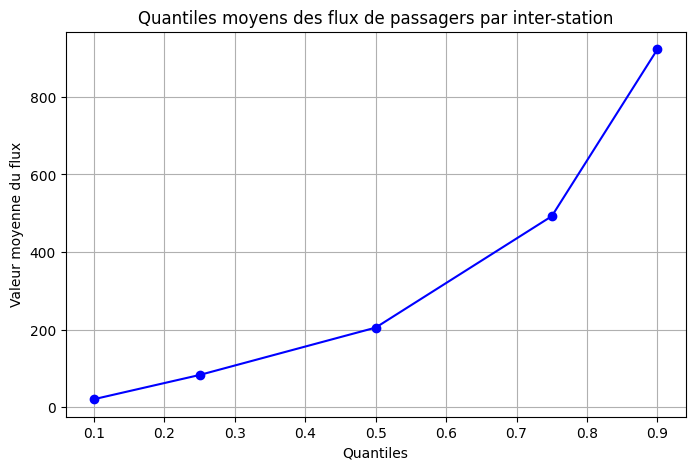

In [ ]:
import torch
import matplotlib.pyplot as plt

# Définition des quantiles à calculer
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_values = {q: 0 for q in quantiles}

# Calcul des quantiles sur l'ensemble du test_loader
for graph, temporal_features in test_loader:
    y = graph.y
    for q in quantiles:
        quantile_values[q] += y.quantile(q)

# Moyenne des quantiles sur l'ensemble du dataset
num_graphs = len(test_loader)
quantile_averages = {q: quantile_values[q] / num_graphs for q in quantiles}

# Tracé du graphique
plt.figure(figsize=(8, 5))
plt.plot(quantiles, list(quantile_averages.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Quantiles")
plt.ylabel("Valeur moyenne du flux")
plt.title("Quantiles moyens des flux de passagers par inter-station")
plt.grid(True)
plt.show()

In [80]:
quantile_averages

{0.1: tensor(21.0093),
 0.25: tensor(83.4183),
 0.5: tensor(205.4930),
 0.75: tensor(492.5528),
 0.9: tensor(922.7127)}